<h1 align="center">First of all -- Checking Questions</h1> 

**Вопрос 1**: Можно ли использовать сверточные сети для классификации текстов? Если нет обоснуйте :D, если да то как? как решить проблему с произвольной длинной входа?

Можно попробовать переводить слова в вектор фиксированной длинны (закодировать, не теряя информации), а на выходе произвести декодирование из вектора такой же длины. Можно банально ограничить длину входа каким-то разумным числом и дописывать терминальные символы в конце слов, если длина меньше.

**Вопрос 2**: Чем LSTM лучше/хуже чем обычная RNN?

В LSTM более продуманная концепция "памяти", которая позволяет лучше прослеживать длинные зависимости, например открытие-закрытие скобок.

**Вопрос 3**:  Выпишите производную $\frac{d c_{n+1}}{d c_{k}}$ для LSTM http://colah.github.io/posts/2015-08-Understanding-LSTMs/, объясните формулу, когда производная затухает, когда взрывается?

<Ответ>

**Вопрос 4**: Зачем нужен TBPTT почему BPTT плох?

В RNN происходит много умножений градиентов в реккурентном слое, так что он либо затухает, либо взрывается. TBPTT помогает решить эту проблему, искуственно обрезая градиенты.

**Вопрос 5**: Как комбинировать рекуррентные и сверточные сети, а главное зачем? Приведите несколько примеров реальных задач.

Это нужно, например, для генерации описаний к видео или картинкам. Выход предобученной сверточной сети (обрезанной до нужного момента) можно подать в $h_0$, а реккурентную обучать, как обычно

**Вопрос 6**: Объясните интуицию выбора размера эмбединг слоя? почему это опасное место?

Ой, вот понимать бы эту интуицию. Я не откажусь узнать ответ)

* Arseniy Ashuha, you can text me ```ars.ashuha@gmail.com```, Александр Панин

<h1 align="center"> Image Captioning </h1> 

In this seminar you'll be going through the image captioning pipeline. It can help u https://ars-ashuha.ru/slides/2016.11.11_ImageCaptioning/image_captionong.pdf 

To begin with, let us download the dataset of image features from a pre-trained GoogleNet.

In [2]:
!wget https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0 -O data.tar.gz
!tar -xvzf data.tar.gz

--2017-05-02 17:15:36--  https://www.dropbox.com/s/d50pqlm19c6f6w5/data.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 108.160.172.238
Connecting to www.dropbox.com (www.dropbox.com)|108.160.172.238|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/pwbIo02NvUGzM6518qWo0ODcchm0u14GIz8Q6yWqF2ksbdDySMXZn7Yig1HycGjc/file [following]
--2017-05-02 17:15:36--  https://dl.dropboxusercontent.com/content_link/pwbIo02NvUGzM6518qWo0ODcchm0u14GIz8Q6yWqF2ksbdDySMXZn7Yig1HycGjc/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.2.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.2.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 506221998 (483M) [application/octet-stream]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>] 482.77M  46.4MB/s    in 10s     

2017-05-02 17:15:47 (48.3 MB/s) - ‘data.tar.gz’ saved [

### Data preprocessing

In [3]:
%%time
# Read Dataset
import numpy as np
import pickle

data_dir = 'data/'

img_codes = np.load(data_dir + 'image_codes.npy')
captions = pickle.load(open(data_dir + 'caption_tokens.pcl', 'rb'))

CPU times: user 600 ms, sys: 396 ms, total: 996 ms
Wall time: 2.31 s


In [4]:
print("each image code is a 1000-unit vector:", img_codes.shape)
print(img_codes[0,:10])
print('\n\n')
print("for each image there are 5-7 descriptions, e.g.:\n")
print('\n'.join(captions[0]))

each image code is a 1000-unit vector: (123287, 1000)
[ 1.38901556 -3.82951474 -1.94360816 -0.5317238  -0.03120959 -2.87483215
 -2.9554503   0.6960277  -0.68551242 -0.7855981 ]



for each image there are 5-7 descriptions, e.g.:

a man with a red helmet on a small moped on a dirt road
man riding a motor bike on a dirt road on the countryside
a man riding on the back of a motorcycle
a dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud wreathed mountains
a man in a red shirt and a red hat is on a motorcycle on a hill side


In [5]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"] + sentence.split(' ') + ["#END#"]
        if not img_i and not caption_i:
            print(captions[img_i][caption_i])

['#START#', 'a', 'man', 'with', 'a', 'red', 'helmet', 'on', 'a', 'small', 'moped', 'on', 'a', 'dirt', 'road', '#END#']


In [6]:
# Build a Vocabulary

word_counts = {}
for img_captions in captions:
    for caption in img_captions:
        for word in caption:
            if word not in word_counts:
                word_counts[word] = 0
            word_counts[word] += 1

vocab  = ['#UNK#']
vocab += [k for k, v in word_counts.items() if v >= 5]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
PAD_ix = -1
UNK_ix = vocab.index('#UNK#')

def as_matrix(sequences,max_len=None):
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences),max_len),dtype='int32')+PAD_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word,UNK_ix) for word in seq[:max_len]]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[ 7874,  6438,  9531,  1920, 10280,  9356,  7303,  6659,  1821,
         1638,  1145,  9709,  2066,    -1,    -1],
       [ 7874,  1821,  1638,  6887,  9617,  1547,  9709,  1145,  7149,
         3341,  7303,  2066,    -1,    -1,    -1],
       [ 7874,  7619,  1920, 10280,  9356,  7303,  6659,  1821,   189,
         2285,  1033,  1288,  1634,   886,  2066],
       [ 7874,  7619,  8014,  7715,  5705,  7927,  7619,  8014,   503,
         2066,    -1,    -1,    -1,    -1,    -1],
       [ 7874,  6438,  9531,  1920, 10280,  9356,  7303,  6659,  1821,
         1638,  1033,  1288,  3315,  2066,    -1]], dtype=int32)

### Mah Neural Network

In [9]:
# network shapes. 
CNN_FEATURE_SIZE = img_codes.shape[1]
EMBED_SIZE = 200 #pls change me if u want
LSTM_UNITS = 512 #pls change me if u want

In [10]:
# other constants
GRAB_CLIPPING = 10

In [11]:
import theano
import lasagne
import theano.tensor as T
from lasagne.layers import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)


In [14]:
# Input Variable
sentences = T.imatrix()# [batch_size x time] of word ids
image_vectors = T.matrix() # [batch size x unit] of CNN image features
sentence_mask = T.neq(sentences, PAD_ix)

In [15]:
# network inputs
l_words = InputLayer((None, None), sentences)
l_mask = InputLayer((None, None), sentence_mask)

# embeddings for words
l_word_embeddings = EmbeddingLayer(l_words, n_tokens, EMBED_SIZE)

In [16]:
# input layer for image features
l_image_features = InputLayer((None, CNN_FEATURE_SIZE), image_vectors)

# convert 1000 image features from googlenet to whatever LSTM_UNITS you have set
# it's also a good idea to add some dropout here and there
l_image_features_small = DropoutLayer(l_image_features, 0.5)
l_image_features_small = DenseLayer(l_image_features_small, LSTM_UNITS)
l_image_features_small = DropoutLayer(l_image_features_small, 0.5)
assert l_image_features_small.output_shape == (None, LSTM_UNITS)

In [17]:
# Concatinate image features and word embedings in one sequence 
stack1 = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=GRAB_CLIPPING)

stack2 = LSTMLayer(l_word_embeddings,
                    num_units=LSTM_UNITS,
                    cell_init=l_image_features_small,
                    mask_input=l_mask,
                    grad_clipping=GRAB_CLIPPING)
decoder = ElemwiseSumLayer([stack1, stack2])

In [18]:
# Decoding of rnn hiden states
from broadcast import BroadcastLayer, UnbroadcastLayer

#apply whatever comes next to each tick of each example in a batch. Equivalent to 2 reshapes
broadcast_decoder_ticks = BroadcastLayer(decoder, (0, 1))
print("broadcasted decoder shape = ", broadcast_decoder_ticks.output_shape)

predicted_probabilities_each_tick = DenseLayer(
    broadcast_decoder_ticks,n_tokens, nonlinearity=lasagne.nonlinearities.softmax)

#un-broadcast back into (batch,tick,probabilities)
predicted_probabilities = UnbroadcastLayer(
    predicted_probabilities_each_tick, broadcast_layer=broadcast_decoder_ticks)

print("output shape = ", predicted_probabilities.output_shape)

# remove if you know what you're doing (e.g. 1d convolutions or fixed shape)
# Yes, I know, what I do. Words "#START#" and "#END#" was duplicated in vocabulary according to baseline  
assert predicted_probabilities.output_shape == (None, None, 10371)

broadcasted decoder shape =  (None, 512)
output shape =  (None, None, 10371)


In [19]:
next_word_probas = get_output(predicted_probabilities)

reference_answers = sentences[:,1:]
output_mask = sentence_mask[:,1:]

# write symbolic loss function to train NN for
loss = lasagne.objectives.categorical_crossentropy(
    next_word_probas[:, :-1].reshape((-1, n_tokens)),
    reference_answers.reshape((-1,))
).reshape(reference_answers.shape)

loss = T.mean(loss[output_mask.nonzero()])

In [20]:
#trainable NN weights
weights = lasagne.layers.get_all_params(predicted_probabilities, trainable=True)
print(weights)

lr = 0.001
sh_lr = theano.shared(lasagne.utils.floatX(lr))
updates = lasagne.updates.adam(loss, weights, learning_rate=sh_lr)

[W, W, b, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b]


In [21]:
#compile a function that takes input sentence and image mask, outputs loss and updates weights
#please not that your functions must accept image features as FIRST param and sentences as second one
train_step = theano.function([image_vectors, sentences], loss, updates=updates, allow_input_downcast=True)
val_step   = theano.function([image_vectors, sentences], loss, allow_input_downcast=True)

# Training

* You first have to implement a batch generator
* Than the network will get trained the usual way

In [22]:
captions = np.array(captions)

In [23]:
from random import choice

def generate_batch(images,captions,batch_size,max_caption_len=None):
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(images), size=batch_size)
    
    #get images
    batch_images = images[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick 1 from 5-7 captions for each image
    batch_captions = list(map(choice, captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return batch_images, batch_captions_ix

In [24]:
generate_batch(img_codes, captions, 3)

(array([[-3.94445515, -1.73868847, -2.95929265, ...,  0.57321161,
          4.1538558 ,  3.58591843],
        [-1.50915837, -3.68247271, -1.18710506, ..., -2.62727499,
          1.57304311, -2.28329706],
        [-4.58010912,  0.23833881,  0.56554478, ..., -0.47391194,
          1.06550336, -1.7917031 ]], dtype=float32),
 array([[7874, 5711, 8014,   56, 9299, 8014,  759,  979, 8092, 2066,   -1,
           -1,   -1,   -1,   -1,   -1],
        [7874, 6438, 1741, 1686, 9355, 2476, 1145, 7619, 3379, 6659, 5377,
         1145, 7149, 2762, 8922, 2066],
        [7874, 3026, 6887, 4253, 3678, 9189, 4945,  759,  462, 2066,   -1,
           -1,   -1,   -1,   -1,   -1]], dtype=int32))

### Main loop
* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again

In [25]:
batch_size = 100 #adjust me
n_epochs   = 1000 #adjust me
n_batches_per_epoch = 50 #adjust me
n_validation_batches = 8 #how many batches are used for validation after each epoch
coef = 0.7
sh_lr.set_value(lasagne.utils.floatX(0.001))

In [26]:
from tqdm import tqdm

for epoch in range(n_epochs):
    if epoch % 25 == 0:
        new_lr = sh_lr.get_value() * coef
        print("New learning rate: {:.9f}".format(new_lr))
        sh_lr.set_value(lasagne.utils.floatX(new_lr))
    train_loss=0
    for _ in tqdm(range(n_batches_per_epoch)):
        train_loss += train_step(*generate_batch(img_codes,captions,batch_size))
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    for _ in range(n_validation_batches):
        val_loss += val_step(*generate_batch(img_codes,captions,batch_size))
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finish :)")

  0%|          | 0/50 [00:00<?, ?it/s]

New learning rate: 0.000700000


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 0, train loss: 6.2408920001983645, val loss: 5.265855026245117


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 1, train loss: 5.045351600646972, val loss: 4.792338180541992


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 4.633343572616577, val loss: 4.387156963348389


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 3, train loss: 4.227328600883484, val loss: 4.092001056671142


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 4.000969700813293, val loss: 4.043570566177368


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 5, train loss: 3.871753010749817, val loss: 3.72133526802063


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 6, train loss: 3.755603723526001, val loss: 3.7961583614349363


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 7, train loss: 3.67100227355957, val loss: 3.614922046661377


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 8, train loss: 3.5985358142852784, val loss: 3.6472774028778074


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 9, train loss: 3.5326960277557373, val loss: 3.5122693538665772


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 10, train loss: 3.459785008430481, val loss: 3.419139003753662


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 11, train loss: 3.4220492219924927, val loss: 3.3941604137420653


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 12, train loss: 3.3517651891708375, val loss: 3.4236021041870117


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 13, train loss: 3.3304270696640015, val loss: 3.2702629566192627


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 14, train loss: 3.3120083093643187, val loss: 3.208464241027832


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 15, train loss: 3.249634737968445, val loss: 3.2907698154449463


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 16, train loss: 3.2094722032546996, val loss: 3.2850059032440186


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 17, train loss: 3.2326293182373047, val loss: 3.172671175003052


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 18, train loss: 3.175508942604065, val loss: 3.1848790645599365


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 19, train loss: 3.129034652709961, val loss: 3.074737024307251


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 20, train loss: 3.152633938789368, val loss: 3.030464839935303


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 21, train loss: 3.0988700866699217, val loss: 3.0925832271575926


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 22, train loss: 3.106582841873169, val loss: 3.076089286804199


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 23, train loss: 3.0543421792984007, val loss: 3.055494689941406


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 24, train loss: 3.073343334197998, val loss: 2.9646482944488524
New learning rate: 0.000490000


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 25, train loss: 3.0539114475250244, val loss: 3.0908374309539797


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 26, train loss: 3.0336275053024293, val loss: 3.001602840423584


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 27, train loss: 3.018376364707947, val loss: 2.9787630081176757


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 28, train loss: 3.002822141647339, val loss: 2.9489097595214844


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 29, train loss: 3.0047885894775392, val loss: 3.0066650390625


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 30, train loss: 2.991889863014221, val loss: 2.9730048179626465


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 31, train loss: 2.9521902132034303, val loss: 2.934270715713501


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 32, train loss: 2.9616036081314085, val loss: 2.947024202346802


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 33, train loss: 2.9630446100234984, val loss: 2.938259983062744


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 34, train loss: 2.945816617012024, val loss: 2.973446083068848


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 35, train loss: 2.918142976760864, val loss: 2.8815098285675047


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 36, train loss: 2.9269071865081786, val loss: 2.9904597282409666


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 37, train loss: 2.9195879125595092, val loss: 2.9575344562530517


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 38, train loss: 2.9169642305374146, val loss: 2.8868085861206056


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 39, train loss: 2.9009917688369753, val loss: 2.92740421295166


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 40, train loss: 2.9019125938415526, val loss: 2.894753122329712


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 41, train loss: 2.8390248155593873, val loss: 2.8109780311584474


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 42, train loss: 2.8561354160308836, val loss: 2.8521993160247803


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 43, train loss: 2.867910327911377, val loss: 2.93082594871521


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 44, train loss: 2.8831245374679564, val loss: 2.8584556579589844


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 45, train loss: 2.8363086223602294, val loss: 2.8309496879577636


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 46, train loss: 2.843063235282898, val loss: 2.8137643814086912


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 47, train loss: 2.8665425395965576, val loss: 2.8868587493896483


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 48, train loss: 2.8513094425201415, val loss: 2.826307010650635


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 49, train loss: 2.832719383239746, val loss: 2.8503326416015624
New learning rate: 0.000343000


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 50, train loss: 2.8426388835906984, val loss: 2.887072706222534


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 51, train loss: 2.793020873069763, val loss: 2.812418746948242


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 52, train loss: 2.7981772375106813, val loss: 2.777712917327881


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 53, train loss: 2.8303066539764403, val loss: 2.787000036239624


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 54, train loss: 2.7986261320114134, val loss: 2.8434874057769775


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 55, train loss: 2.806059007644653, val loss: 2.7676655292510985


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 56, train loss: 2.803435115814209, val loss: 2.8356186866760256


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 57, train loss: 2.7846807479858398, val loss: 2.777586030960083


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 58, train loss: 2.792400588989258, val loss: 2.834175777435303


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 59, train loss: 2.797329640388489, val loss: 2.7403133869171143


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 60, train loss: 2.8142587661743166, val loss: 2.8146291255950926


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 61, train loss: 2.765140624046326, val loss: 2.7818249225616456


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 62, train loss: 2.778087019920349, val loss: 2.7977948665618895


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 63, train loss: 2.7480768156051636, val loss: 2.859084415435791


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 64, train loss: 2.7291438388824463, val loss: 2.812076377868652


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 65, train loss: 2.7726379013061524, val loss: 2.745382213592529


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 66, train loss: 2.744062452316284, val loss: 2.6981932640075685


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 67, train loss: 2.7385835027694703, val loss: 2.7793453693389893


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 68, train loss: 2.765607228279114, val loss: 2.6891419887542725


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 69, train loss: 2.7553497886657716, val loss: 2.7089828491210937


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 70, train loss: 2.7267068147659304, val loss: 2.7104071617126464


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 71, train loss: 2.709591727256775, val loss: 2.732722043991089


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 72, train loss: 2.7764819765090945, val loss: 2.6415382385253907


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 73, train loss: 2.725641531944275, val loss: 2.819005250930786


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 74, train loss: 2.7101556921005248, val loss: 2.7129517555236817
New learning rate: 0.000240100


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 75, train loss: 2.739892406463623, val loss: 2.7838265895843506


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 76, train loss: 2.7186643362045286, val loss: 2.740616226196289


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 77, train loss: 2.713164143562317, val loss: 2.7032832145690917


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 78, train loss: 2.724698166847229, val loss: 2.666653776168823


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 79, train loss: 2.718442831039429, val loss: 2.742932081222534


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 80, train loss: 2.7028379440307617, val loss: 2.699766826629639


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 81, train loss: 2.691524453163147, val loss: 2.741565704345703


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 82, train loss: 2.7121959018707273, val loss: 2.8130971908569338


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 83, train loss: 2.722072196006775, val loss: 2.7906835079193115


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 84, train loss: 2.7187177610397337, val loss: 2.639811372756958


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 85, train loss: 2.716247420310974, val loss: 2.6742709159851072


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 86, train loss: 2.7141749095916747, val loss: 2.694653034210205


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 87, train loss: 2.679160280227661, val loss: 2.73113694190979


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 88, train loss: 2.6809777784347535, val loss: 2.80973539352417


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 89, train loss: 2.6882829809188844, val loss: 2.6811453819274904


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 90, train loss: 2.707670588493347, val loss: 2.7092562675476075


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 91, train loss: 2.6635994148254394, val loss: 2.6609484195709228


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 92, train loss: 2.685950684547424, val loss: 2.698619031906128


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 93, train loss: 2.675727334022522, val loss: 2.7281928062438965


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 94, train loss: 2.6816899490356447, val loss: 2.6797446250915526


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 95, train loss: 2.674772787094116, val loss: 2.6305352687835692


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 96, train loss: 2.6390166664123536, val loss: 2.7184903144836428


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 97, train loss: 2.6790911197662353, val loss: 2.6495912075042725


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 98, train loss: 2.6627978086471558, val loss: 2.6621835708618162


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 99, train loss: 2.6642972087860106, val loss: 2.69052939414978
New learning rate: 0.000168070


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 100, train loss: 2.647018008232117, val loss: 2.6213176250457764


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 101, train loss: 2.661160736083984, val loss: 2.6470932483673097


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 102, train loss: 2.6840534257888793, val loss: 2.633640766143799


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 103, train loss: 2.6713672494888305, val loss: 2.693291187286377


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 104, train loss: 2.6583053922653197, val loss: 2.590097427368164


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 105, train loss: 2.672248182296753, val loss: 2.5757484912872313


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 106, train loss: 2.663741445541382, val loss: 2.628343915939331


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 107, train loss: 2.654253239631653, val loss: 2.7296849727630614


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 108, train loss: 2.6655829048156736, val loss: 2.5907671451568604


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 109, train loss: 2.6723475790023805, val loss: 2.6245348930358885


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 110, train loss: 2.6616617250442505, val loss: 2.677960968017578


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 111, train loss: 2.66988582611084, val loss: 2.6006000518798826


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 112, train loss: 2.6413501024246218, val loss: 2.612132167816162


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 113, train loss: 2.6494792795181272, val loss: 2.5766111850738525


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 114, train loss: 2.6572829198837282, val loss: 2.616270923614502


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 115, train loss: 2.6384136962890623, val loss: 2.6927669048309326


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 116, train loss: 2.6288069009780886, val loss: 2.653542232513428


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 117, train loss: 2.631559534072876, val loss: 2.6164864540100097


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 118, train loss: 2.6331519317626952, val loss: 2.5782542705535887


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 119, train loss: 2.641488108634949, val loss: 2.6692593574523924


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 120, train loss: 2.6390462017059324, val loss: 2.5952273845672607


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 121, train loss: 2.6508416891098023, val loss: 2.6125580310821532


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 122, train loss: 2.6424307727813723, val loss: 2.6615777015686035


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 123, train loss: 2.6451050281524657, val loss: 2.559630107879639


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 124, train loss: 2.653078122138977, val loss: 2.6470625400543213
New learning rate: 0.000117649


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 125, train loss: 2.6331320142745973, val loss: 2.6031017303466797


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 126, train loss: 2.6219240331649782, val loss: 2.683091640472412


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 127, train loss: 2.6379959630966185, val loss: 2.556893253326416


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 128, train loss: 2.6300416469573973, val loss: 2.600966739654541


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 129, train loss: 2.6366506576538087, val loss: 2.648190212249756


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 130, train loss: 2.633400526046753, val loss: 2.622659683227539


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 131, train loss: 2.627907295227051, val loss: 2.6248661041259767


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 132, train loss: 2.610792050361633, val loss: 2.64360990524292


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 133, train loss: 2.6290470123291017, val loss: 2.646192121505737


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 134, train loss: 2.6137650632858276, val loss: 2.6832136154174804


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 135, train loss: 2.6543740367889406, val loss: 2.621669960021973


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 136, train loss: 2.6359065341949464, val loss: 2.5985167026519775


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 137, train loss: 2.6125700092315673, val loss: 2.590391731262207


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 138, train loss: 2.617906241416931, val loss: 2.6403821468353272


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 139, train loss: 2.6121563148498534, val loss: 2.6153401851654055


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 140, train loss: 2.6079688262939453, val loss: 2.656956672668457


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 141, train loss: 2.634965763092041, val loss: 2.6248019218444822


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 142, train loss: 2.6101600408554075, val loss: 2.5624056816101075


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 143, train loss: 2.6097790718078615, val loss: 2.6420094966888428


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 144, train loss: 2.643836050033569, val loss: 2.6438761711120606


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 145, train loss: 2.608701033592224, val loss: 2.658022737503052


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 146, train loss: 2.6170745420455934, val loss: 2.59838547706604


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 147, train loss: 2.6267885541915894, val loss: 2.590363311767578


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 148, train loss: 2.5909802532196045, val loss: 2.6692975997924804


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 149, train loss: 2.609703497886658, val loss: 2.5770578384399414
New learning rate: 0.000082354


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 150, train loss: 2.609645447731018, val loss: 2.5997201919555666


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 151, train loss: 2.5979300928115845, val loss: 2.708431768417358


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 152, train loss: 2.6124887228012086, val loss: 2.514681911468506


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 153, train loss: 2.5983713150024412, val loss: 2.5499897480010985


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 154, train loss: 2.6069179439544676, val loss: 2.6473047733306885


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 155, train loss: 2.5950374746322633, val loss: 2.553282642364502


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 156, train loss: 2.596164193153381, val loss: 2.544242286682129


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 157, train loss: 2.607155833244324, val loss: 2.566005754470825


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 158, train loss: 2.6080313682556153, val loss: 2.5813058376312257


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 159, train loss: 2.629963312149048, val loss: 2.5945943355560304


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 160, train loss: 2.5916389560699464, val loss: 2.5825833320617675


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 161, train loss: 2.6189625310897826, val loss: 2.707110643386841


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 162, train loss: 2.5990723514556886, val loss: 2.6163943290710447


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 163, train loss: 2.5680895137786863, val loss: 2.596204137802124


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 164, train loss: 2.5916483497619627, val loss: 2.540455532073975


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 165, train loss: 2.6187136793136596, val loss: 2.5928120613098145


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 166, train loss: 2.6034037256240845, val loss: 2.5860878944396974


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 167, train loss: 2.585911569595337, val loss: 2.593594789505005


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 168, train loss: 2.5891856002807616, val loss: 2.5521031856536864


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 169, train loss: 2.6048033237457275, val loss: 2.5019965171813965


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 170, train loss: 2.5856823825836184, val loss: 2.672408866882324


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 171, train loss: 2.598223247528076, val loss: 2.6239459991455076


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 172, train loss: 2.607696394920349, val loss: 2.5554255485534667


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 173, train loss: 2.61100266456604, val loss: 2.5331260204315185


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 174, train loss: 2.5973105144500734, val loss: 2.5597381591796875
New learning rate: 0.000057648


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 175, train loss: 2.6033712911605833, val loss: 2.595790719985962


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 176, train loss: 2.587852177619934, val loss: 2.6446807861328123


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 177, train loss: 2.575811562538147, val loss: 2.553312826156616


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 178, train loss: 2.6032991552352907, val loss: 2.63946647644043


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 179, train loss: 2.586602683067322, val loss: 2.6224645137786866


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 180, train loss: 2.613031668663025, val loss: 2.591647005081177


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 181, train loss: 2.578084554672241, val loss: 2.6287940979003905


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 182, train loss: 2.5934399652481077, val loss: 2.6402857303619385


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 183, train loss: 2.5835468673706057, val loss: 2.5995905876159666


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 184, train loss: 2.571800990104675, val loss: 2.5623281478881834


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 185, train loss: 2.574550633430481, val loss: 2.635040521621704


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 186, train loss: 2.5866152000427247, val loss: 2.606855010986328


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 187, train loss: 2.561687779426575, val loss: 2.585391473770142


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 188, train loss: 2.5617673540115358, val loss: 2.624867153167725


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 189, train loss: 2.583079986572266, val loss: 2.559182596206665


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 190, train loss: 2.586430506706238, val loss: 2.6362202167510986


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 191, train loss: 2.6042194986343383, val loss: 2.594692897796631


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 192, train loss: 2.5916410970687864, val loss: 2.6345646381378174


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 193, train loss: 2.5842384243011476, val loss: 2.597551155090332


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 194, train loss: 2.603888974189758, val loss: 2.5122958183288575


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 195, train loss: 2.5908399534225466, val loss: 2.601993274688721


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 196, train loss: 2.5621556663513183, val loss: 2.5628594398498534


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 197, train loss: 2.5457406187057496, val loss: 2.5838622570037844


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 198, train loss: 2.584793210029602, val loss: 2.479073476791382


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 199, train loss: 2.5569572257995605, val loss: 2.674467754364014
New learning rate: 0.000040354


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 200, train loss: 2.5791544818878176, val loss: 2.5895071029663086


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 201, train loss: 2.5931843519210815, val loss: 2.601481008529663


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 202, train loss: 2.5756322002410887, val loss: 2.5796197414398194


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 203, train loss: 2.5950409364700318, val loss: 2.5763378143310547


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 204, train loss: 2.5754102087020874, val loss: 2.6356320858001707


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 205, train loss: 2.588669195175171, val loss: 2.5433324337005616


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 206, train loss: 2.577419819831848, val loss: 2.6401095390319824


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 207, train loss: 2.567702331542969, val loss: 2.5548003673553468


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 208, train loss: 2.578739104270935, val loss: 2.54992733001709


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 209, train loss: 2.56176043510437, val loss: 2.5656454086303713


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 210, train loss: 2.595089168548584, val loss: 2.609021472930908


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 211, train loss: 2.5741237783432007, val loss: 2.561482620239258


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 212, train loss: 2.5695335912704467, val loss: 2.667989492416382


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 213, train loss: 2.5639683389663697, val loss: 2.6232556819915773


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 214, train loss: 2.5890737438201903, val loss: 2.604956102371216


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 215, train loss: 2.583966679573059, val loss: 2.625489282608032


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 216, train loss: 2.5897243547439577, val loss: 2.614031934738159


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 217, train loss: 2.5732342624664306, val loss: 2.5531715869903566


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 218, train loss: 2.5863958168029786, val loss: 2.6375572681427


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 219, train loss: 2.5781860542297363, val loss: 2.5346580505371095


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 220, train loss: 2.5640208387374877, val loss: 2.5941510677337645


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 221, train loss: 2.5858909606933596, val loss: 2.5542479515075684


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 222, train loss: 2.562432312965393, val loss: 2.546567106246948


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 223, train loss: 2.553063325881958, val loss: 2.6239444255828857


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 224, train loss: 2.6006781101226806, val loss: 2.5599196910858155
New learning rate: 0.000028248


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 225, train loss: 2.559332914352417, val loss: 2.5340038776397704


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 226, train loss: 2.5803702783584597, val loss: 2.4998974323272707


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 227, train loss: 2.572197685241699, val loss: 2.570840072631836


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 228, train loss: 2.5858324337005616, val loss: 2.569877195358276


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 229, train loss: 2.5648011493682863, val loss: 2.628901481628418


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 230, train loss: 2.5653401756286622, val loss: 2.606244945526123


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 231, train loss: 2.5573376417160034, val loss: 2.600666332244873


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 232, train loss: 2.563591923713684, val loss: 2.585539770126343


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 233, train loss: 2.5703165340423584, val loss: 2.572416973114014


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 234, train loss: 2.562714409828186, val loss: 2.553473424911499


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 235, train loss: 2.5771929836273193, val loss: 2.5508153438568115


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 236, train loss: 2.5863566255569457, val loss: 2.580381488800049


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 237, train loss: 2.5825365924835206, val loss: 2.657981204986572


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 238, train loss: 2.5833683156967164, val loss: 2.5888683795928955


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 239, train loss: 2.5536844539642334, val loss: 2.6129456996917724


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 240, train loss: 2.59551655292511, val loss: 2.619822120666504


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 241, train loss: 2.5639638471603394, val loss: 2.5832887649536134


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 242, train loss: 2.5543730640411377, val loss: 2.5318691730499268


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 243, train loss: 2.5539054536819457, val loss: 2.537011814117432


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 244, train loss: 2.5722967767715454, val loss: 2.5029226303100587


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 245, train loss: 2.575691499710083, val loss: 2.590763807296753


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 246, train loss: 2.57962571144104, val loss: 2.623935174942017


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 247, train loss: 2.569547915458679, val loss: 2.5575717449188233


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 248, train loss: 2.5471736097335818, val loss: 2.488975763320923


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 249, train loss: 2.5668672704696656, val loss: 2.5719072818756104
New learning rate: 0.000019773


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 250, train loss: 2.5696957159042357, val loss: 2.594370889663696


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 251, train loss: 2.560488476753235, val loss: 2.597220754623413


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 252, train loss: 2.5449814939498903, val loss: 2.6353257656097413


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 253, train loss: 2.593719959259033, val loss: 2.5589263916015623


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 254, train loss: 2.5673306083679197, val loss: 2.591742181777954


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 255, train loss: 2.5722778367996217, val loss: 2.5400598526000975


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 256, train loss: 2.564048137664795, val loss: 2.5272663593292237


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 257, train loss: 2.5752005624771117, val loss: 2.649776554107666


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 258, train loss: 2.578495740890503, val loss: 2.586504650115967


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 259, train loss: 2.5683070373535157, val loss: 2.540395402908325


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 260, train loss: 2.586185460090637, val loss: 2.546398735046387


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 261, train loss: 2.579440975189209, val loss: 2.553257703781128


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 262, train loss: 2.5929310274124147, val loss: 2.463247776031494


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 263, train loss: 2.5478610229492187, val loss: 2.5340073108673096


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 264, train loss: 2.560902132987976, val loss: 2.5277516841888428


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 265, train loss: 2.5457026958465576, val loss: 2.6223313331604006


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 266, train loss: 2.5713570737838745, val loss: 2.6596845626831054


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 267, train loss: 2.562693462371826, val loss: 2.5854174137115478


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 268, train loss: 2.5650550937652588, val loss: 2.5084196090698243


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 269, train loss: 2.567824625968933, val loss: 2.637508916854858


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 270, train loss: 2.5802578735351562, val loss: 2.482130765914917


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 271, train loss: 2.5835662698745727, val loss: 2.5170244693756105


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 272, train loss: 2.567971177101135, val loss: 2.5654491424560546


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 273, train loss: 2.5883870458602907, val loss: 2.5386229515075684


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 274, train loss: 2.555627064704895, val loss: 2.5317124366760253
New learning rate: 0.000013841


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 275, train loss: 2.5873238801956178, val loss: 2.4951562881469727


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 276, train loss: 2.5882254457473755, val loss: 2.6531276226043703


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 277, train loss: 2.560044569969177, val loss: 2.670301628112793


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 278, train loss: 2.573087887763977, val loss: 2.523001289367676


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 279, train loss: 2.5862485933303834, val loss: 2.623541069030762


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 280, train loss: 2.558739895820618, val loss: 2.545452833175659


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 281, train loss: 2.5623642873764036, val loss: 2.564036178588867


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 282, train loss: 2.6023033809661866, val loss: 2.52503924369812


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 283, train loss: 2.555984926223755, val loss: 2.6036403656005858


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 284, train loss: 2.541236152648926, val loss: 2.598811674118042


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 285, train loss: 2.556040186882019, val loss: 2.5839948654174805


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 286, train loss: 2.5780474042892454, val loss: 2.5671531200408935


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 287, train loss: 2.5656955909729002, val loss: 2.543150043487549


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 288, train loss: 2.572950592041016, val loss: 2.4873424053192137


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 289, train loss: 2.5586424827575684, val loss: 2.603764772415161


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 290, train loss: 2.5913004875183105, val loss: 2.5219730377197265


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 291, train loss: 2.547802796363831, val loss: 2.576127815246582


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 292, train loss: 2.570855360031128, val loss: 2.6251787185668944


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 293, train loss: 2.5735015726089476, val loss: 2.5880855560302733


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 294, train loss: 2.5353134870529175, val loss: 2.613425636291504


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 295, train loss: 2.5760482788085937, val loss: 2.539587450027466


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 296, train loss: 2.555221815109253, val loss: 2.5878765106201174


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 297, train loss: 2.576034007072449, val loss: 2.6577277183532715


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 298, train loss: 2.572385239601135, val loss: 2.5492741107940673


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 299, train loss: 2.55753981590271, val loss: 2.505566358566284
New learning rate: 0.000009689


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 300, train loss: 2.5705181312561036, val loss: 2.4892293930053713


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 301, train loss: 2.5550152111053466, val loss: 2.5191831588745117


  2%|▏         | 1/50 [00:00<00:24,  1.99it/s]


KeyboardInterrupt: 

### apply trained model

In [27]:
#the same kind you did last week, but a bit smaller
from pretrained_lenet import build_model, preprocess, MEAN_VALUES

# build googlenet
lenet = build_model()

#load weights
lenet_weights = pickle.load(open(data_dir + 'blvc_googlenet.pkl', 'rb'), encoding='latin1')['param values']
set_all_param_values(lenet["prob"], lenet_weights)

#compile get_features
cnn_input_var = lenet['input'].input_var
cnn_feature_layer = lenet['loss3/classifier']
get_cnn_features = theano.function([cnn_input_var], lasagne.layers.get_output(cnn_feature_layer))

In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

#sample image
img = plt.imread(data_dir + 'Dog-and-Cat.jpg')
img = preprocess(img)

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


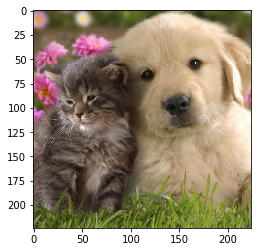

In [29]:
#deprocess and show, one line :)
from pretrained_lenet import MEAN_VALUES
plt.imshow(np.transpose((img[0] + MEAN_VALUES)[::-1],[1, 2, 0]).astype('uint8'))

## Generate caption

In [40]:
last_word_probas_det = get_output(predicted_probabilities,deterministic=False)[:,-1]

get_probs = theano.function([image_vectors,sentences], last_word_probas_det)

#this is exactly the generation function from week5 classwork,
#except now we condition on image features instead of words
def generate_caption(image,caption_prefix = ("START",),t=1,sample=True,max_len=100):
    image_features = get_cnn_features(image)
    caption = list(caption_prefix)
    for _ in range(max_len):
        
        next_word_probs = get_probs(image_features,as_matrix([caption]) ).ravel()
        #apply temperature
        next_word_probs = next_word_probs**t / np.sum(next_word_probs**t)

        if sample:
            next_word = np.random.choice(vocab,p=next_word_probs) 
        else:
            next_word = vocab[np.argmax(next_word_probs)]

        caption.append(next_word)

        if next_word=="#END#":
            break
            
    return caption

In [41]:
for i in range(10):
    print(' '.join(generate_caption(img,t=2.)[1:-1]) + '\n')

a small cat sitting next to a black cat

a large white cat is sitting on a chair

#UNK# dog is in the grass with a frisbee

two white cat standing in a grassy area

white dog with a frisbee in its mouth

a black and white cat is laying on a chair

two gray and white dogs sitting on a couch

small white cat sitting on a blue chair

someones cat is laying on a couch

little gray cat looking at a camera



# Bonus Part
- Use ResNet Instead of GoogLeNet
- Use W2V as embedding
- Use Attention :) 

# Pass Assignment https://goo.gl/forms/2qqVtfepn0t1aDgh1 